In [2]:
import numpy as np
import pandas as pd
import torch
device = torch.device("mps")

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Sample data (replace with your actual data)
pop = pd.read_csv('data/songs_liwc_25_04_11.csv').iloc[:, 2:]
pop.columns

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
torch.backends.mps.is_available()
torch.backends.mps.is_built()
device

device(type='mps')

In [ ]:
# processing: currently leaving punctuation alone
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
from gensim.parsing.preprocessing import remove_stopwords
from gensim.utils import simple_preprocess

pop['cleaned_lyrics'] = pop['cleaned_lyrics'].astype(str).apply(remove_stopwords)
pop['lyrics-tokenized'] = pop['cleaned_lyrics'].apply(simple_preprocess)


In [8]:
# emotion detection with distilroberta
# https://huggingface.co/j-hartmann/emotion-english-distilroberta-base
from transformers import pipeline
emotion_model = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    truncation=True,
    device=-1  # Use GPU/MPS if available, change to -1 for CPU if needed
)


In [9]:
# Process the entire column in batch (more efficient than applying row by row)
predictions = emotion_model(pop['cleaned_lyrics'].tolist(), batch_size=8)

print(predictions[:3])

[{'label': 'anger', 'score': 0.2634609341621399}, {'label': 'joy', 'score': 0.8637192249298096}, {'label': 'anger', 'score': 0.8746570348739624}]


In [10]:
# Extract only the emotion label from each prediction
pop['emotion'] = [pred['label'] for pred in predictions]  # Extract emotion labels
pop['emotion_score'] = [pred['score'] for pred in predictions]  # Extract confidence scores


In [11]:
# add NRC
#https://www.geeksforgeeks.org/emotion-classification-using-nrc-lexicon-in-python/
from nrclex import NRCLex

#google ai popup:
def analyze_emotion(text):
    if isinstance(text, str):
        emotion_lexicon = NRCLex(text)
        return emotion_lexicon.raw_emotion_scores
    else:
        return {} 

#pop = pop.join(pop['emotion_scores'].apply(pd.Series))
pop['emotion_scores'] = pop['cleaned_lyrics'].apply(analyze_emotion)

In [12]:
pop = pop.join(pop['emotion_scores'].apply(pd.Series).add_prefix("nrc_"))

C:\Users\asarr\AppData\Local\Temp\ipykernel_17652\2245074140.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pop = pop.join(pop['emotion_scores'].apply(pd.Series).add_prefix("nrc_"))
C:\Users\asarr\AppData\Local\Temp\ipykernel_17652\2245074140.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pop = pop.join(pop['emotion_scores'].apply(pd.Series).add_prefix("nrc_"))
C:\Users\asarr\AppData\Local\Temp\ipykernel_17652\2245074140.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pop = pop.join(pop['emotion_scores'].apply(pd.Series).add_prefix("nrc_"))
C:\Users\asarr\AppData\Local\Temp\ipykernel_17652\2245074140.py:1: FutureWarning: The de

In [13]:
pop.columns

Index(['artist', 'album', 'song', 'lyrics', 'cleaned_lyrics', 'Segment', 'WC',
       'Analytic', 'Clout', 'Authentic',
       ...
       'nrc_trust', 'nrc_anticipation', 'nrc_fear', 'nrc_surprise',
       'nrc_positive', 'nrc_negative', 'nrc_disgust', 'nrc_anger',
       'nrc_sadness', 'nrc_joy'],
      dtype='object', length=137)

In [14]:
# work on PCA -- have distilbert, NRC + LIWC

pop.to_csv('data/songs_expanded_25_04_11.csv', index=False)

In [16]:
# now LIWC, NRC, distilbert all together : time for PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pop_scale =  pop.select_dtypes(include='number').fillna(0)
scl = pd.DataFrame(scaler.fit_transform(pop_scale)) 

In [20]:
scl.columns = pop_scale.columns
scl.head(3)


,Segment,WC,Analytic,Clout,Authentic,Tone,WPS,BigWords,Dic,Linguistic,...,nrc_trust,nrc_anticipation,nrc_fear,nrc_surprise,nrc_positive,nrc_negative,nrc_disgust,nrc_anger,nrc_sadness,nrc_joy
0,0.0,-0.618155,0.873057,1.201296,1.038364,-0.292645,-0.707865,1.591334,0.278223,0.350093,...,-0.709564,-0.525912,-0.182537,-0.482270,-0.794776,-0.384525,-0.132822,-0.478725,-0.418092,-0.773700
1,0.0,-0.460551,-0.634646,1.793907,-1.289670,2.181485,-0.722951,0.138202,0.464881,0.885949,...,0.330547,-0.083342,-0.872737,0.099085,-0.408306,-0.842838,-0.627044,-0.715230,-0.821144,-0.010808
2,0.0,0.252608,1.561161,-0.972845,1.038364,-0.825438,1.864870,-0.596957,0.475012,0.582310,...,-0.501542,-0.415270,0.162564,-0.772948,-0.601541,-0.155368,-0.330511,-0.242220,0.488777,-0.773700


In [21]:
#https://github.com/tirthajyoti/Machine-Learning-with-Python/blob/master/Clustering-Dimensionality-Reduction/Principal%20Component%20Analysis.ipynb 
from sklearn.decomposition import PCA
pca = PCA(n_components=None)
pop_pca = pca.fit(scl)

In [22]:
pop_pca

PCA()

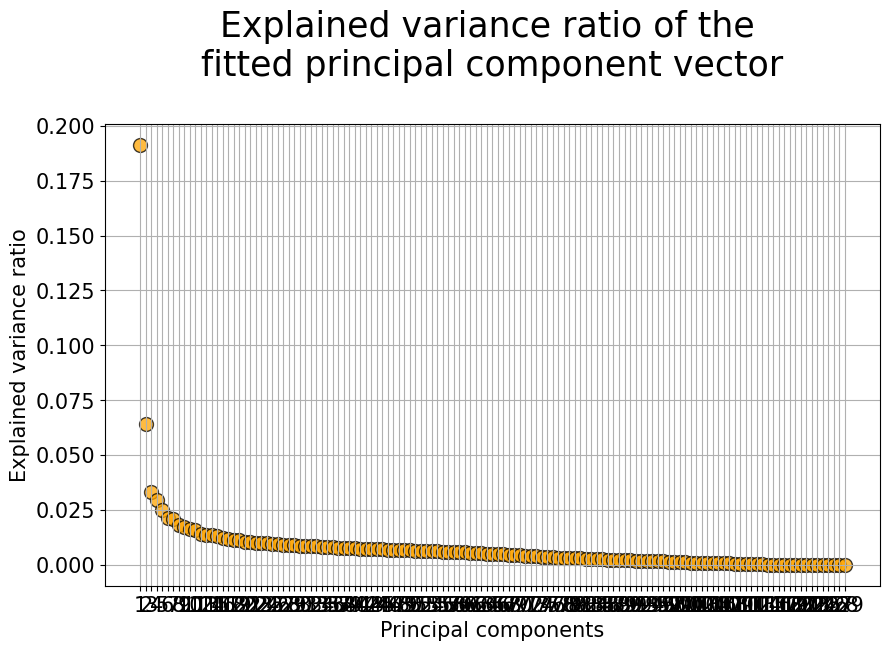

In [25]:
# explained variance ratio 
plt.figure(figsize=(10,6))
plt.scatter(x=[i+1 for i in range(len(pop_pca.explained_variance_ratio_))],
            y=pop_pca.explained_variance_ratio_,
           s=100, alpha=0.75,c='orange',edgecolor='k')
plt.grid(True)
plt.title("Explained variance ratio of the \nfitted principal component vector\n",fontsize=25)
plt.xlabel("Principal components",fontsize=15)
plt.xticks([i+1 for i in range(len(pop_pca.explained_variance_ratio_))],fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Explained variance ratio",fontsize=15)
plt.show()

In [26]:
#number of components to get 90% variance
cumsum = np.cumsum(pop_pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.90) + 1
print(f"Number of components to explain 90% variance: {d}")

Number of components to explain 90% variance: 67


In [ ]:
pop_pca_trans = pd.DataFrame(pca.transform(scl))

[pca] >Extracting column labels from dataframe.
[pca] >The PCA reduction is performed on the [129] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


[scatterd] >INFO> Create scatterplot


[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


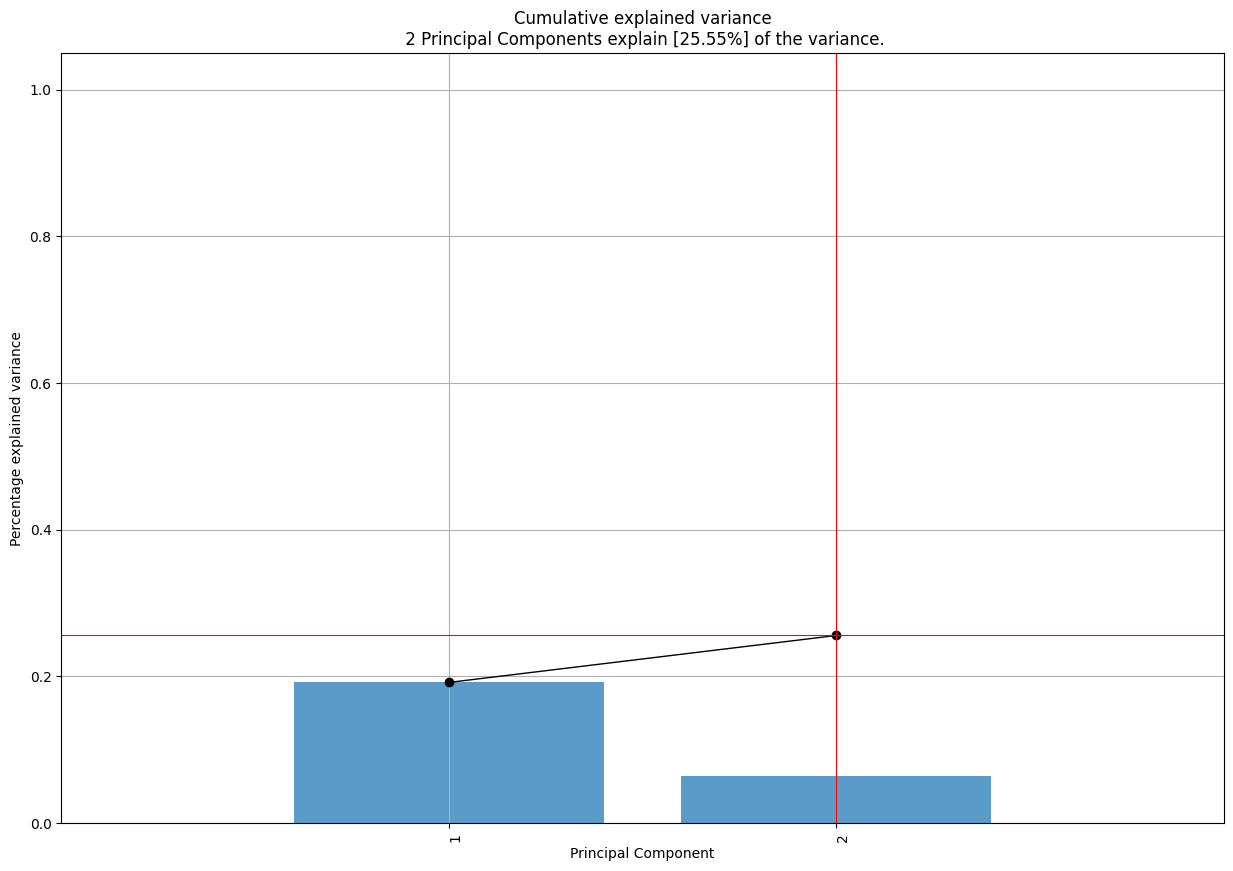

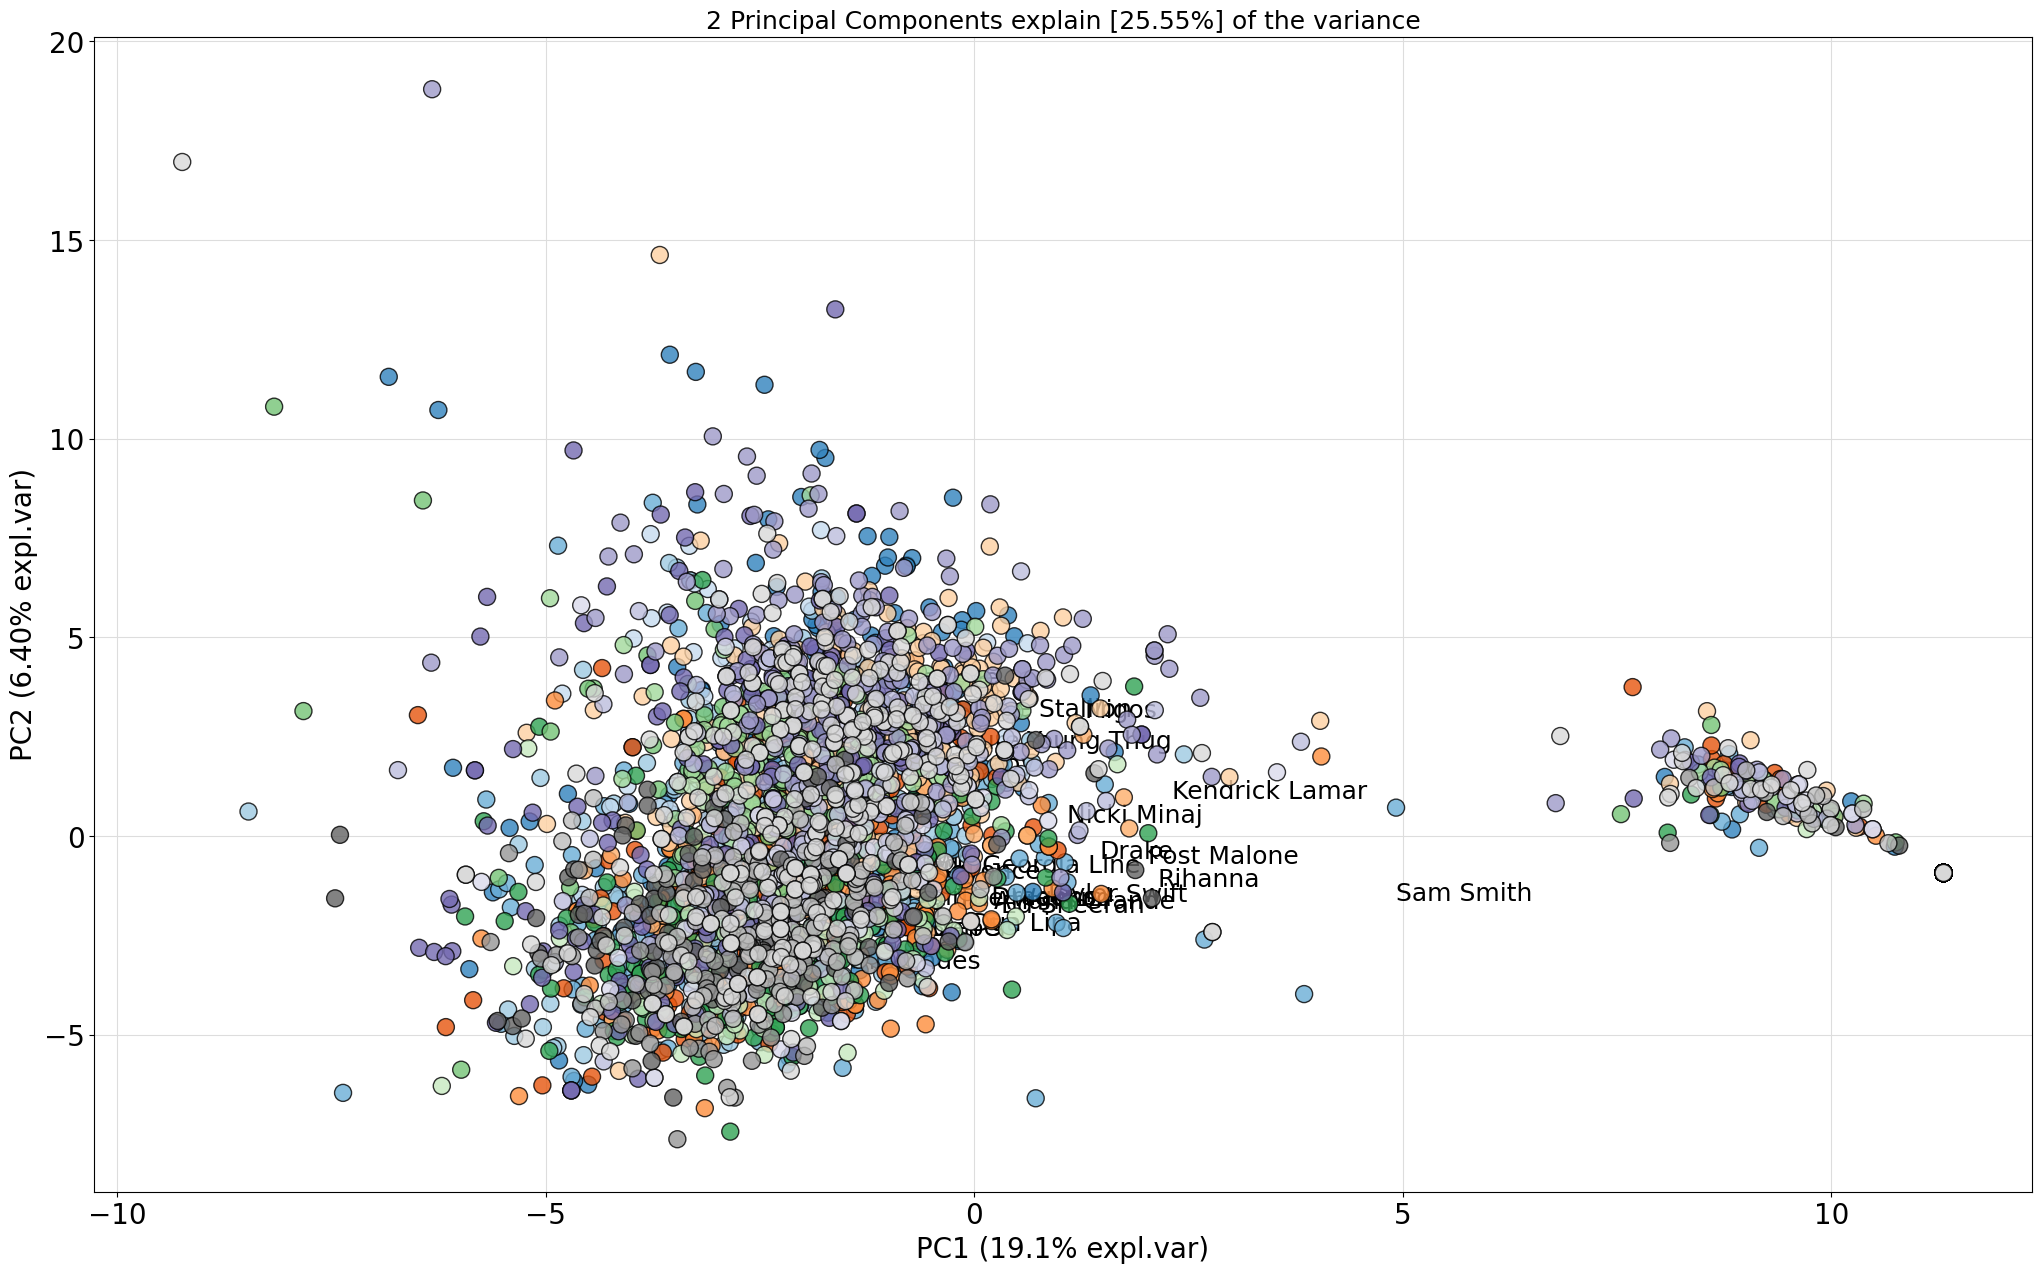

In [27]:
#https://erdogant.github.io/pca/pages/html/index.html
from pca import pca
#model = pca(n_components=0.95)
# ... or explicitly specify the number of PCs
model = pca(n_components=2)

# Fit and transform
results = model.fit_transform(X=scl, row_labels = pop["artist"])

# Plot the explained variance
fig, ax = model.plot()

# Scatter the first two PCs
fig, ax = model.scatter()



[scatterd] >INFO> Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[scatterd] >INFO> Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[scatterd] >INFO> Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[scatterd] >INFO> Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[scatterd] >INFO> Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[scatterd] >INFO> Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[scatterd] >INFO> Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[scatterd] >INFO> Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[scatterd] >INFO> Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[scatterd] >INFO> Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[scatterd] >INFO> Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[scatterd]

[pca] >Plot PC1 vs PC2 with loadings.
[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


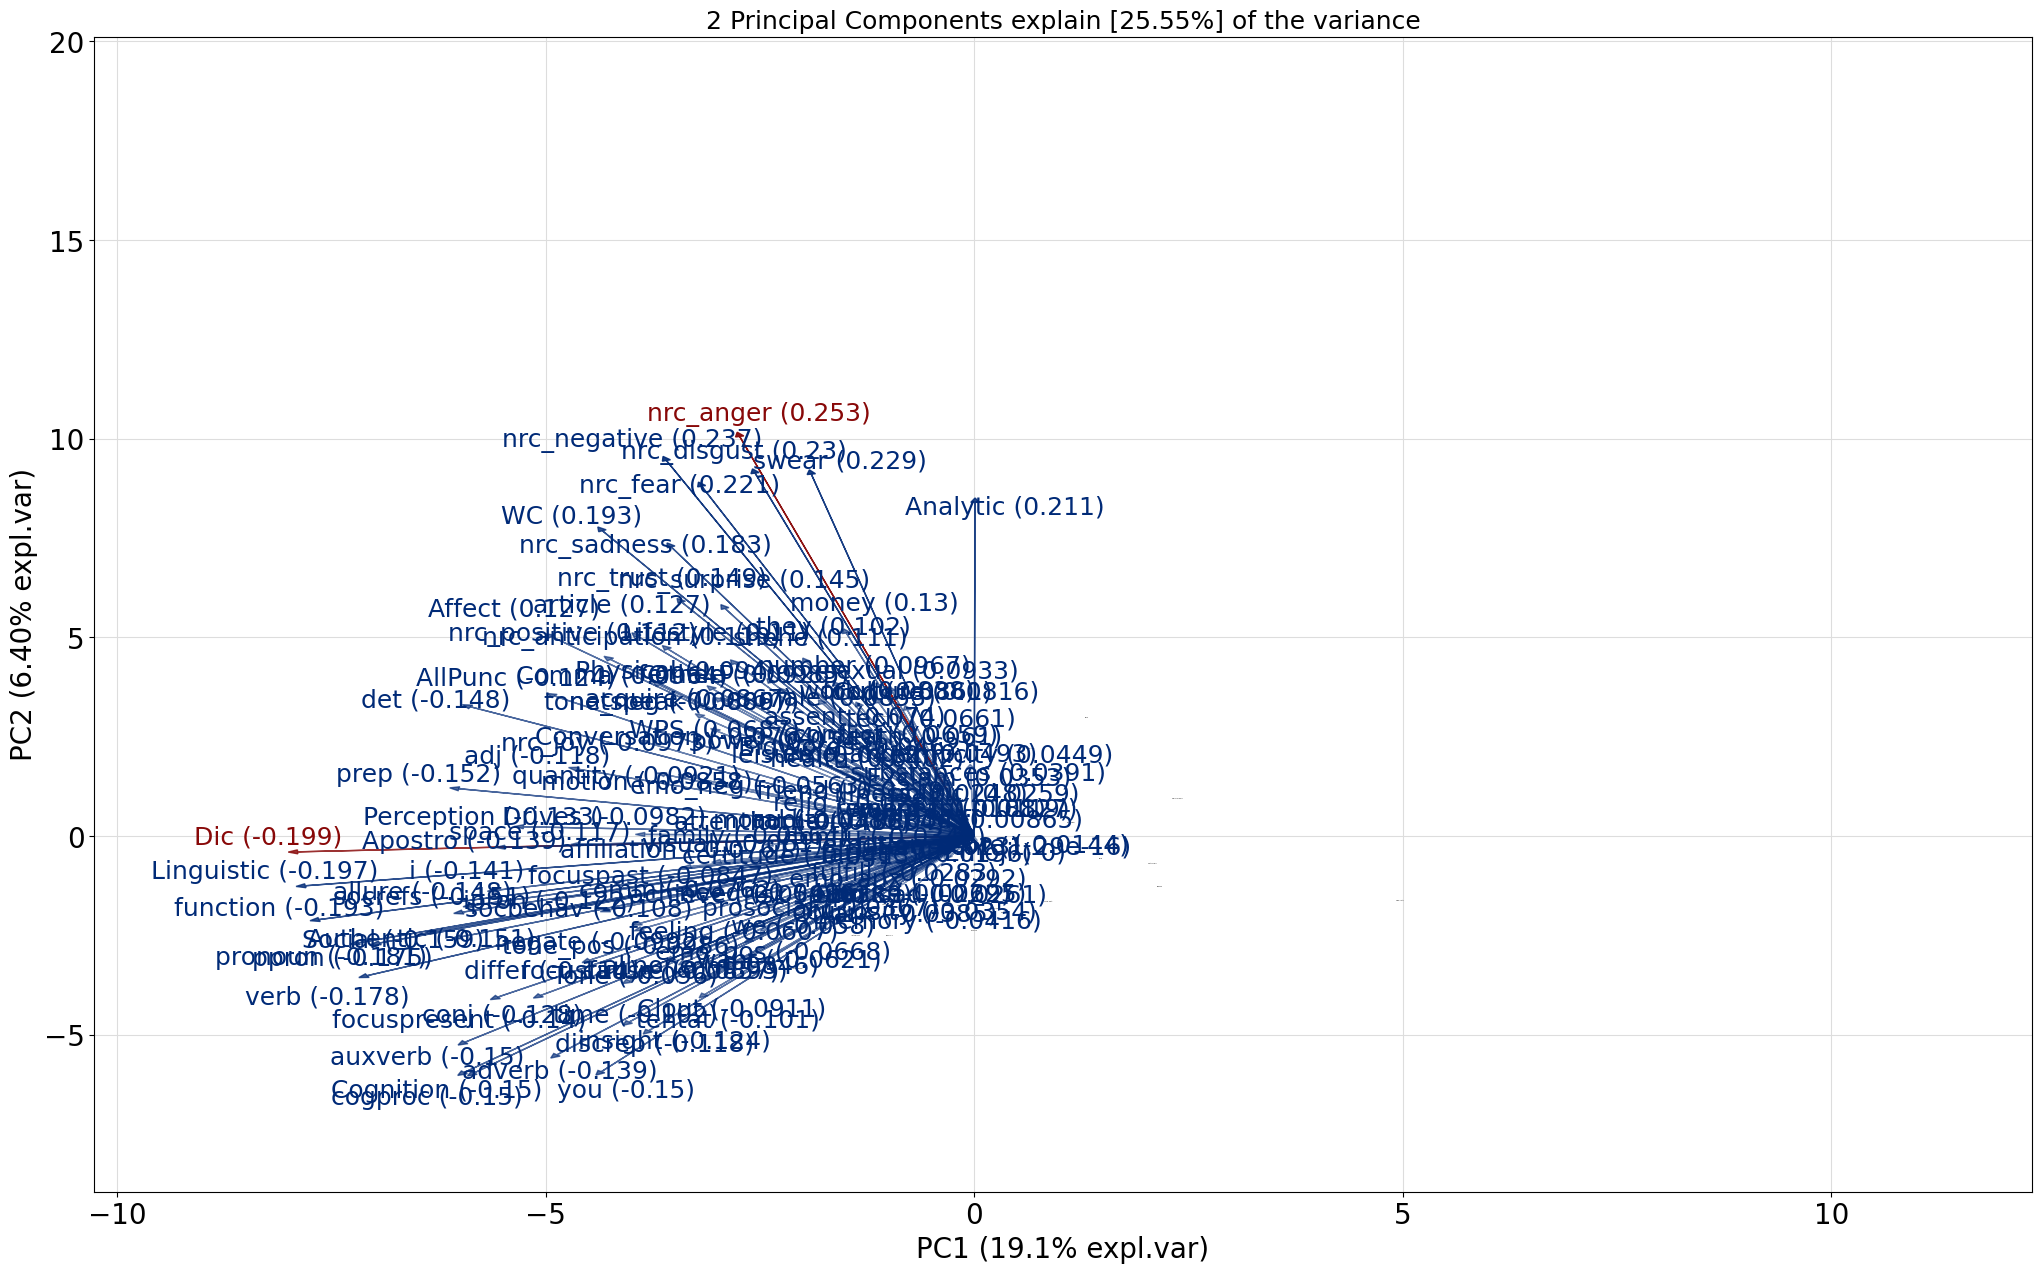

In [32]:
# Create a biplot
fig, ax = model.biplot(n_feat=130, cmap=None)


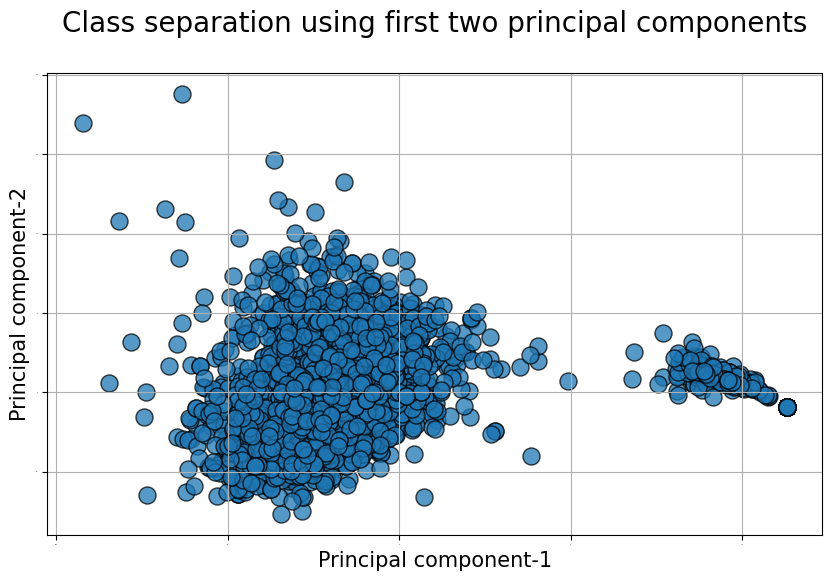

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(pop_pca_trans[0],pop_pca_trans[1],c=pop['artist'], edgecolors='k',alpha=0.75,s=150)
plt.grid(True)
plt.title("Class separation using first two principal components\n",fontsize=20)
plt.xlabel("Principal component-1",fontsize=15)
plt.ylabel("Principal component-2",fontsize=15)
plt.show()

In [30]:
# smaller scale version
# Create a list of columns that start with "nrc_"
nrc_columns = [col for col in pop.columns if col.startswith("nrc_")] + ["Linguistic", "Analytic", "Authentic", "Tone","emo_pos", "emo_neg", "artist", "cleaned_lyrics"]
               

# Filter DataFrame to keep only "nrc_" columns
pop_small = pop[nrc_columns]


# Process the entire column in batch (more efficient than applying row by row)
predictions_sm = emotion_model(pop_small['cleaned_lyrics'].tolist(), batch_size=8)

print(predictions_sm[:3])

[{'label': 'anger', 'score': 0.2634609341621399}, {'label': 'joy', 'score': 0.8637192249298096}, {'label': 'anger', 'score': 0.8746570348739624}]


In [31]:
pop_small.columns


Index(['nrc_trust', 'nrc_anticipation', 'nrc_fear', 'nrc_surprise',
       'nrc_positive', 'nrc_negative', 'nrc_disgust', 'nrc_anger',
       'nrc_sadness', 'nrc_joy', 'Linguistic', 'Analytic', 'Authentic', 'Tone',
       'emo_pos', 'emo_neg', 'artist', 'cleaned_lyrics'],
      dtype='object')

In [33]:
pop_small.loc[:, "row_id"] = pop_small.groupby(["artist", "cleaned_lyrics"]).ngroup()

C:\Users\asarr\AppData\Local\Temp\ipykernel_17652\3035875331.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pop_small.loc[:, "row_id"] = pop_small.groupby(["artist", "cleaned_lyrics"]).ngroup()


In [34]:
# Extract only the emotion label from each prediction
pop_small['emotion'] = [pred['label'] for pred in predictions_sm]  # Extract emotion labels
pop_small['emotion_score'] = [pred['score'] for pred in predictions_sm]  # Extract confidence scores



C:\Users\asarr\AppData\Local\Temp\ipykernel_17652\3572578106.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pop_small['emotion'] = [pred['label'] for pred in predictions_sm]  # Extract emotion labels
C:\Users\asarr\AppData\Local\Temp\ipykernel_17652\3572578106.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pop_small['emotion_score'] = [pred['score'] for pred in predictions_sm]  # Extract confidence scores


In [36]:
# pivot wider:
pop_small_exp = pop_small.pivot_table(
    index=["artist", "cleaned_lyrics"] + [col for col in pop_small.columns if col.startswith("nrc_") or col in ["Linguistic", "Analytic", "Tone", "emo_pos", "emo_neg", "Authentic"]],
    columns="emotion",
    values="emotion_score",
    aggfunc="mean"  # or 'max', 'min', 'first', etc.
).reset_index()



In [37]:
# now LIWC, NRC, distilbert all together : time for PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pop_sm_scale =  pop_small_exp.select_dtypes(include='number').fillna(0)
scl2 = pd.DataFrame(scaler.fit_transform(pop_sm_scale)) 



In [39]:
scl2.columns = pop_sm_scale.columns
scl2.head()


emotion,nrc_trust,nrc_anticipation,nrc_fear,nrc_surprise,nrc_positive,nrc_negative,nrc_disgust,nrc_anger,nrc_sadness,nrc_joy,...,Tone,emo_pos,emo_neg,anger,disgust,fear,joy,neutral,sadness,surprise
0,-0.507519,-0.077274,0.082203,-0.053088,-0.695136,-0.077137,-0.329446,0.399381,-0.712560,-0.430901,...,-1.293646,-0.332011,-0.662175,2.406369,-0.0729,-0.388114,-0.374775,-0.378733,-0.437833,-0.215353
1,-0.608527,-0.513217,2.187635,0.353290,-0.425543,2.536566,2.619785,3.028452,1.041501,-0.688389,...,-0.822914,-0.426985,-0.111616,1.964092,-0.0729,-0.388114,-0.374775,-0.378733,-0.437833,-0.215353
2,-1.113569,-1.058146,0.891984,-0.188547,-1.369119,0.888796,0.500025,0.545440,0.749157,-1.117536,...,-1.282032,-0.078748,0.448435,1.688525,-0.0729,-0.388114,-0.374775,-0.378733,-0.437833,-0.215353
3,0.300549,0.903598,0.163181,-0.053088,0.046245,0.775157,0.315698,0.253321,0.067023,-0.173413,...,-0.720566,-0.199048,-0.377403,1.088804,-0.0729,-0.388114,-0.374775,-0.378733,-0.437833,-0.215353
4,0.906599,0.794612,0.891984,0.759668,0.113643,0.150141,-0.698100,-0.330917,-0.030425,0.684882,...,-0.833077,-0.483969,-0.083139,2.360322,-0.0729,-0.388114,-0.374775,-0.378733,-0.437833,-0.215353


[pca] >Extracting column labels from dataframe.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed on the [23] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


[scatterd] >INFO> Create scatterplot


[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


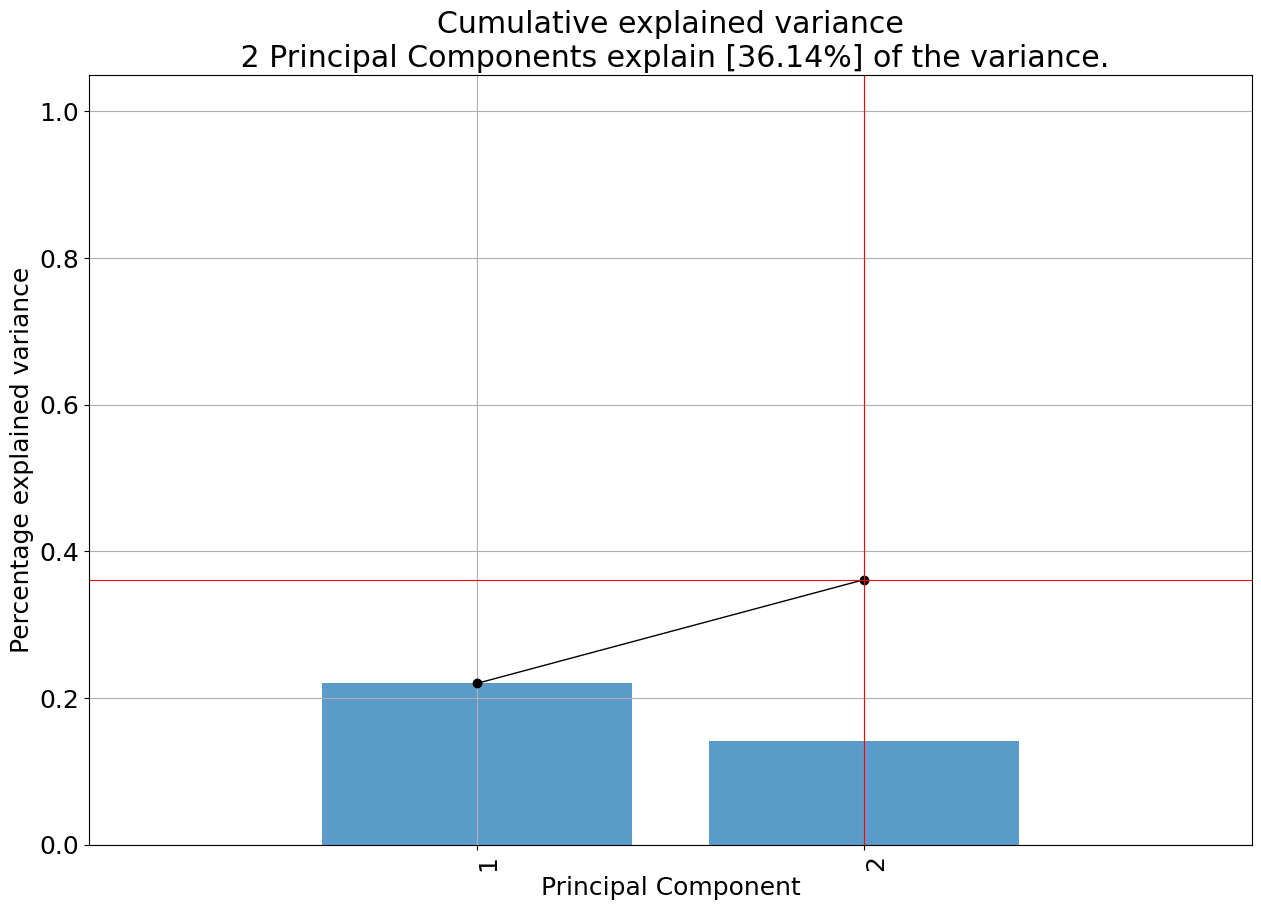

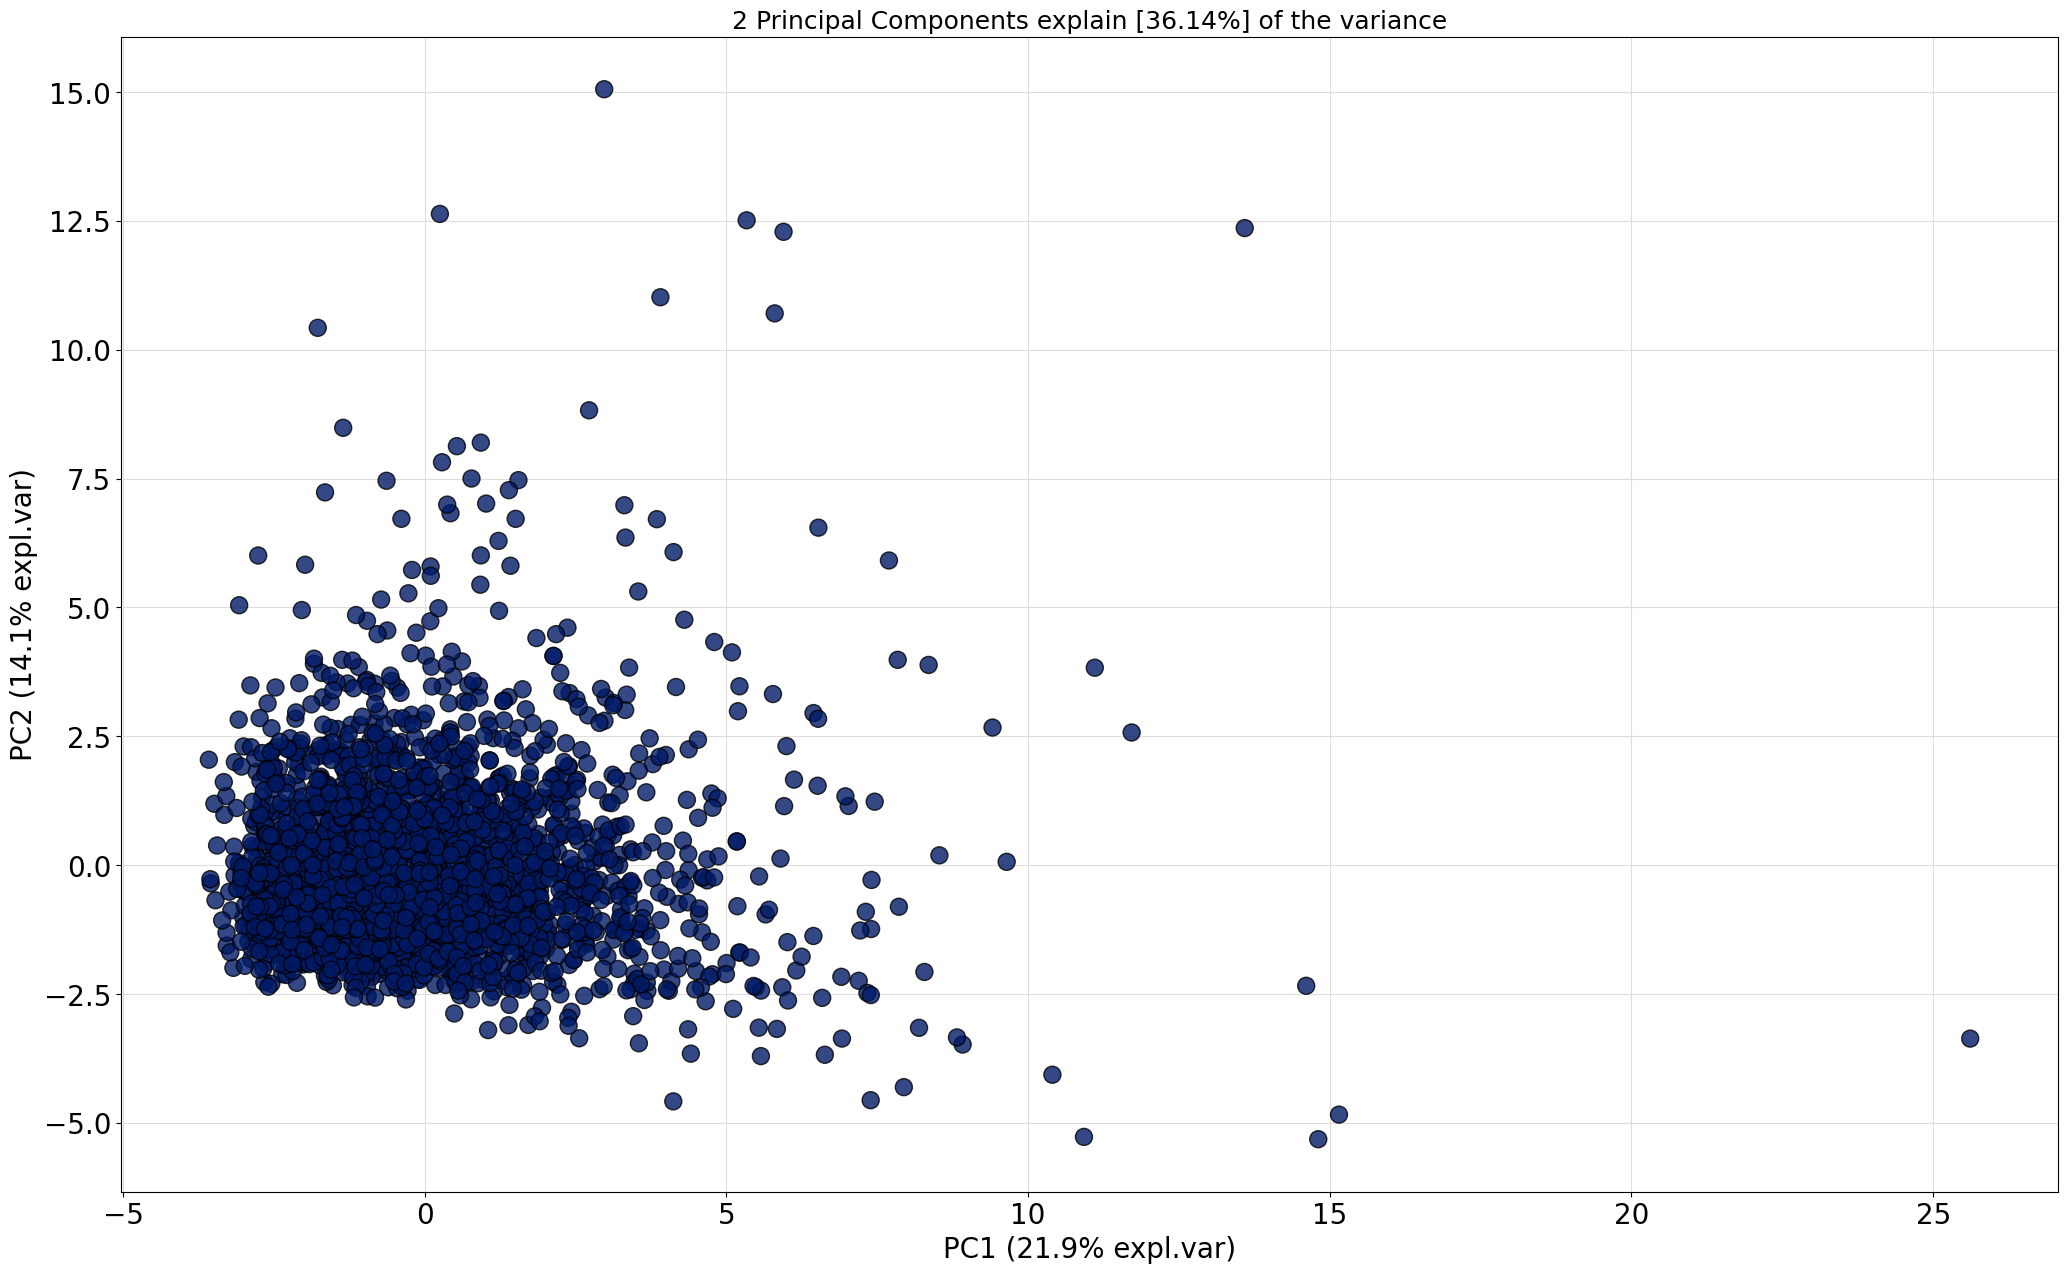

In [40]:
from pca import pca
#model2 = pca(n_components=0.95)
# ... or explicitly specify the number of PCs
model2 = pca(n_components=2)

# Fit and transform
results = model2.fit_transform(X=scl2, row_labels = pop_small["artist"])

# Plot the explained variance
fig, ax = model2.plot()

# Scatter the first two PCs
fig, ax = model2.scatter()


In [ ]:
pop_small_exp.shape

(2447, 25)

[scatterd] >INFO> Create scatterplot


[pca] >Plot PC1 vs PC2 with loadings.
[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


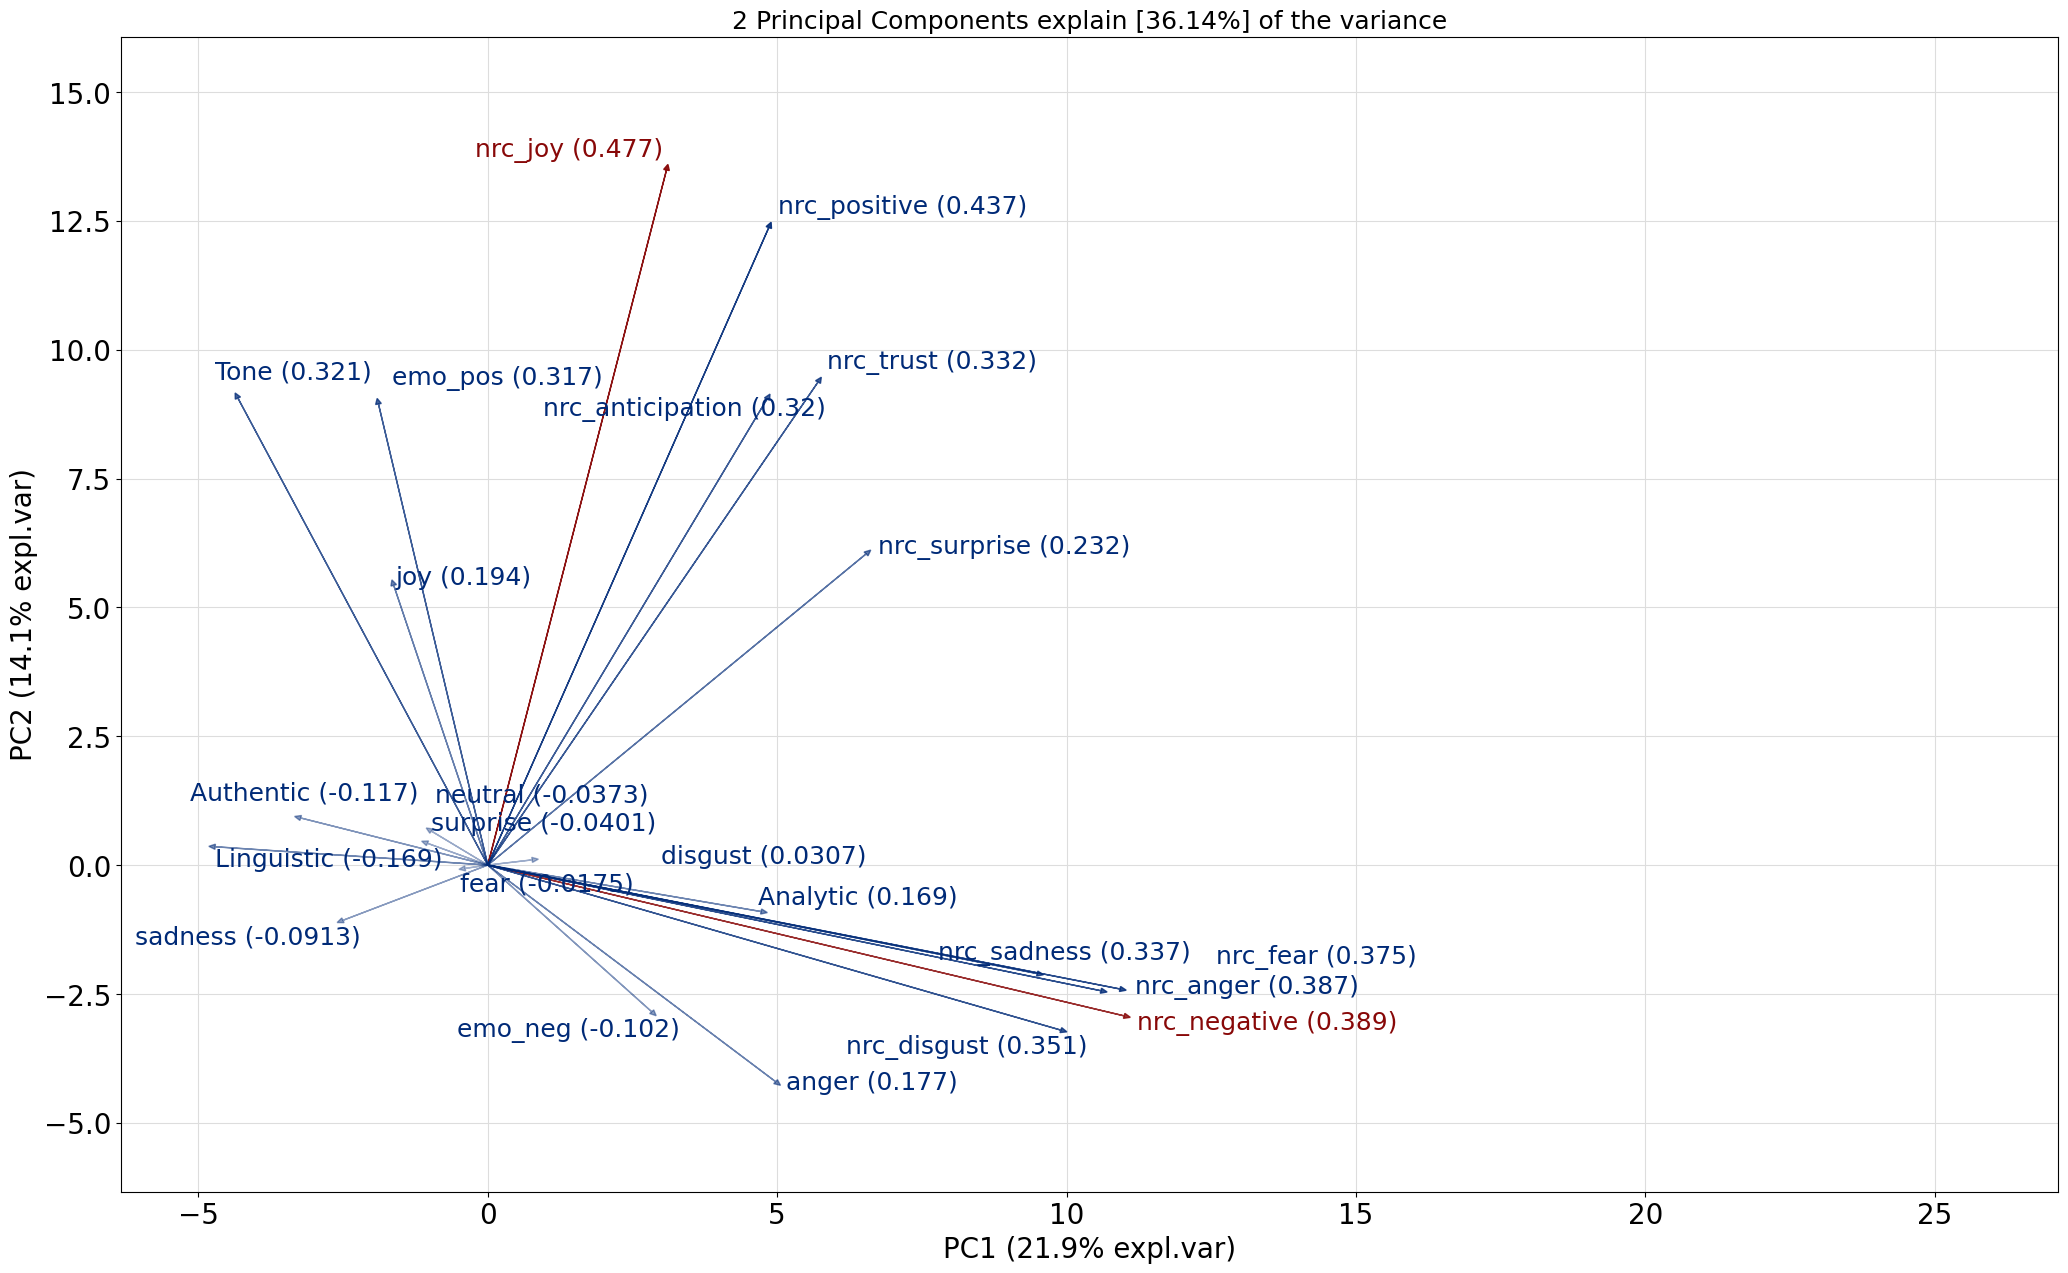

In [42]:
fig, ax = model2.biplot(n_feat=25, cmap=None)

In [43]:
pop_small_exp.columns

Index(['artist', 'cleaned_lyrics', 'nrc_trust', 'nrc_anticipation', 'nrc_fear',
       'nrc_surprise', 'nrc_positive', 'nrc_negative', 'nrc_disgust',
       'nrc_anger', 'nrc_sadness', 'nrc_joy', 'Linguistic', 'Analytic',
       'Authentic', 'Tone', 'emo_pos', 'emo_neg', 'anger', 'disgust', 'fear',
       'joy', 'neutral', 'sadness', 'surprise'],
      dtype='object', name='emotion')

In [44]:
pop_four = pop_small_exp[['Linguistic', 'Analytic', 'joy', 'anger']]

In [45]:
# now LIWC, NRC, distilbert all together : time for PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pop_four_scale =  pop_four.select_dtypes(include='number').fillna(0)
scl3 = pd.DataFrame(scaler.fit_transform(pop_four_scale)) 

scl3.columns = pop_four_scale.columns
scl3.head()

emotion,Linguistic,Analytic,joy,anger
0,-0.660076,-0.645488,-0.374775,2.406369
1,-0.923106,-0.405418,-0.374775,1.964092
2,-1.341450,1.545102,-0.374775,1.688525
3,0.041339,-0.173145,-0.374775,1.088804
4,-0.204156,1.526225,-0.374775,2.360322


[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed on the [4] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[3]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


[scatterd] >INFO> Create scatterplot


[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


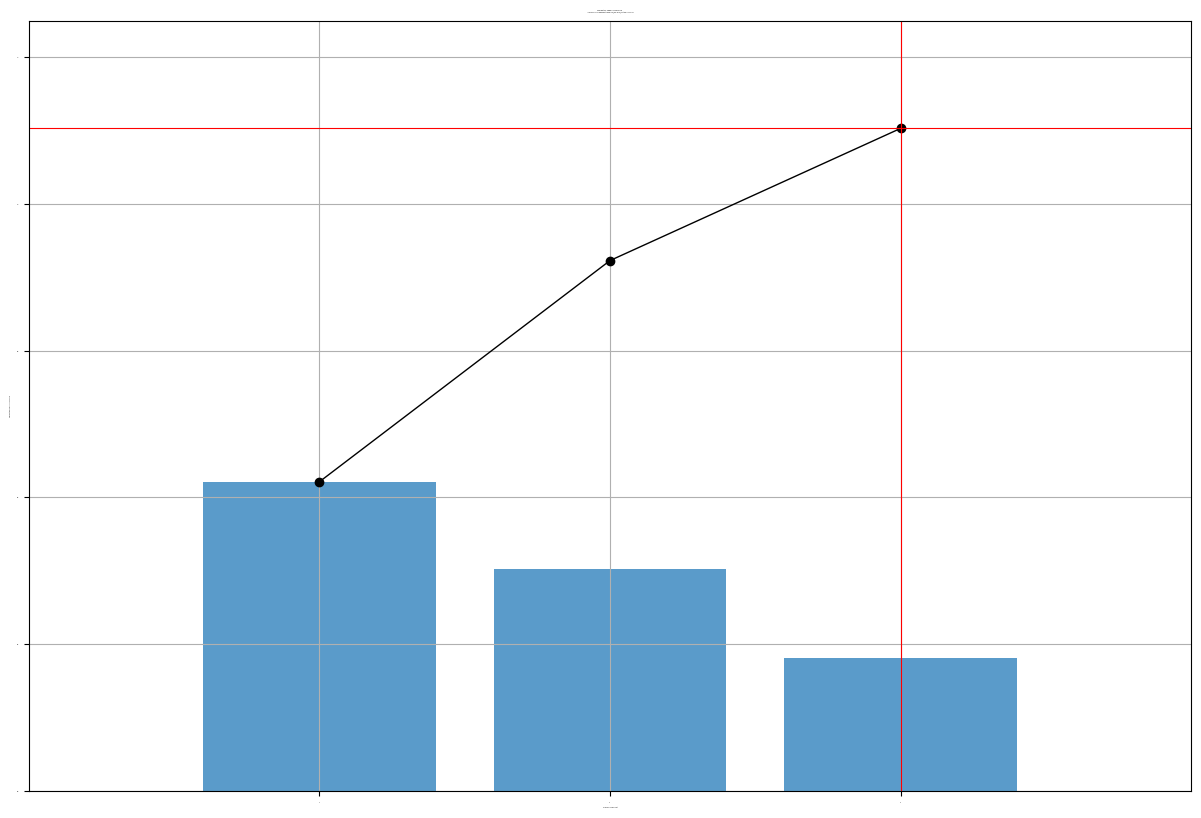

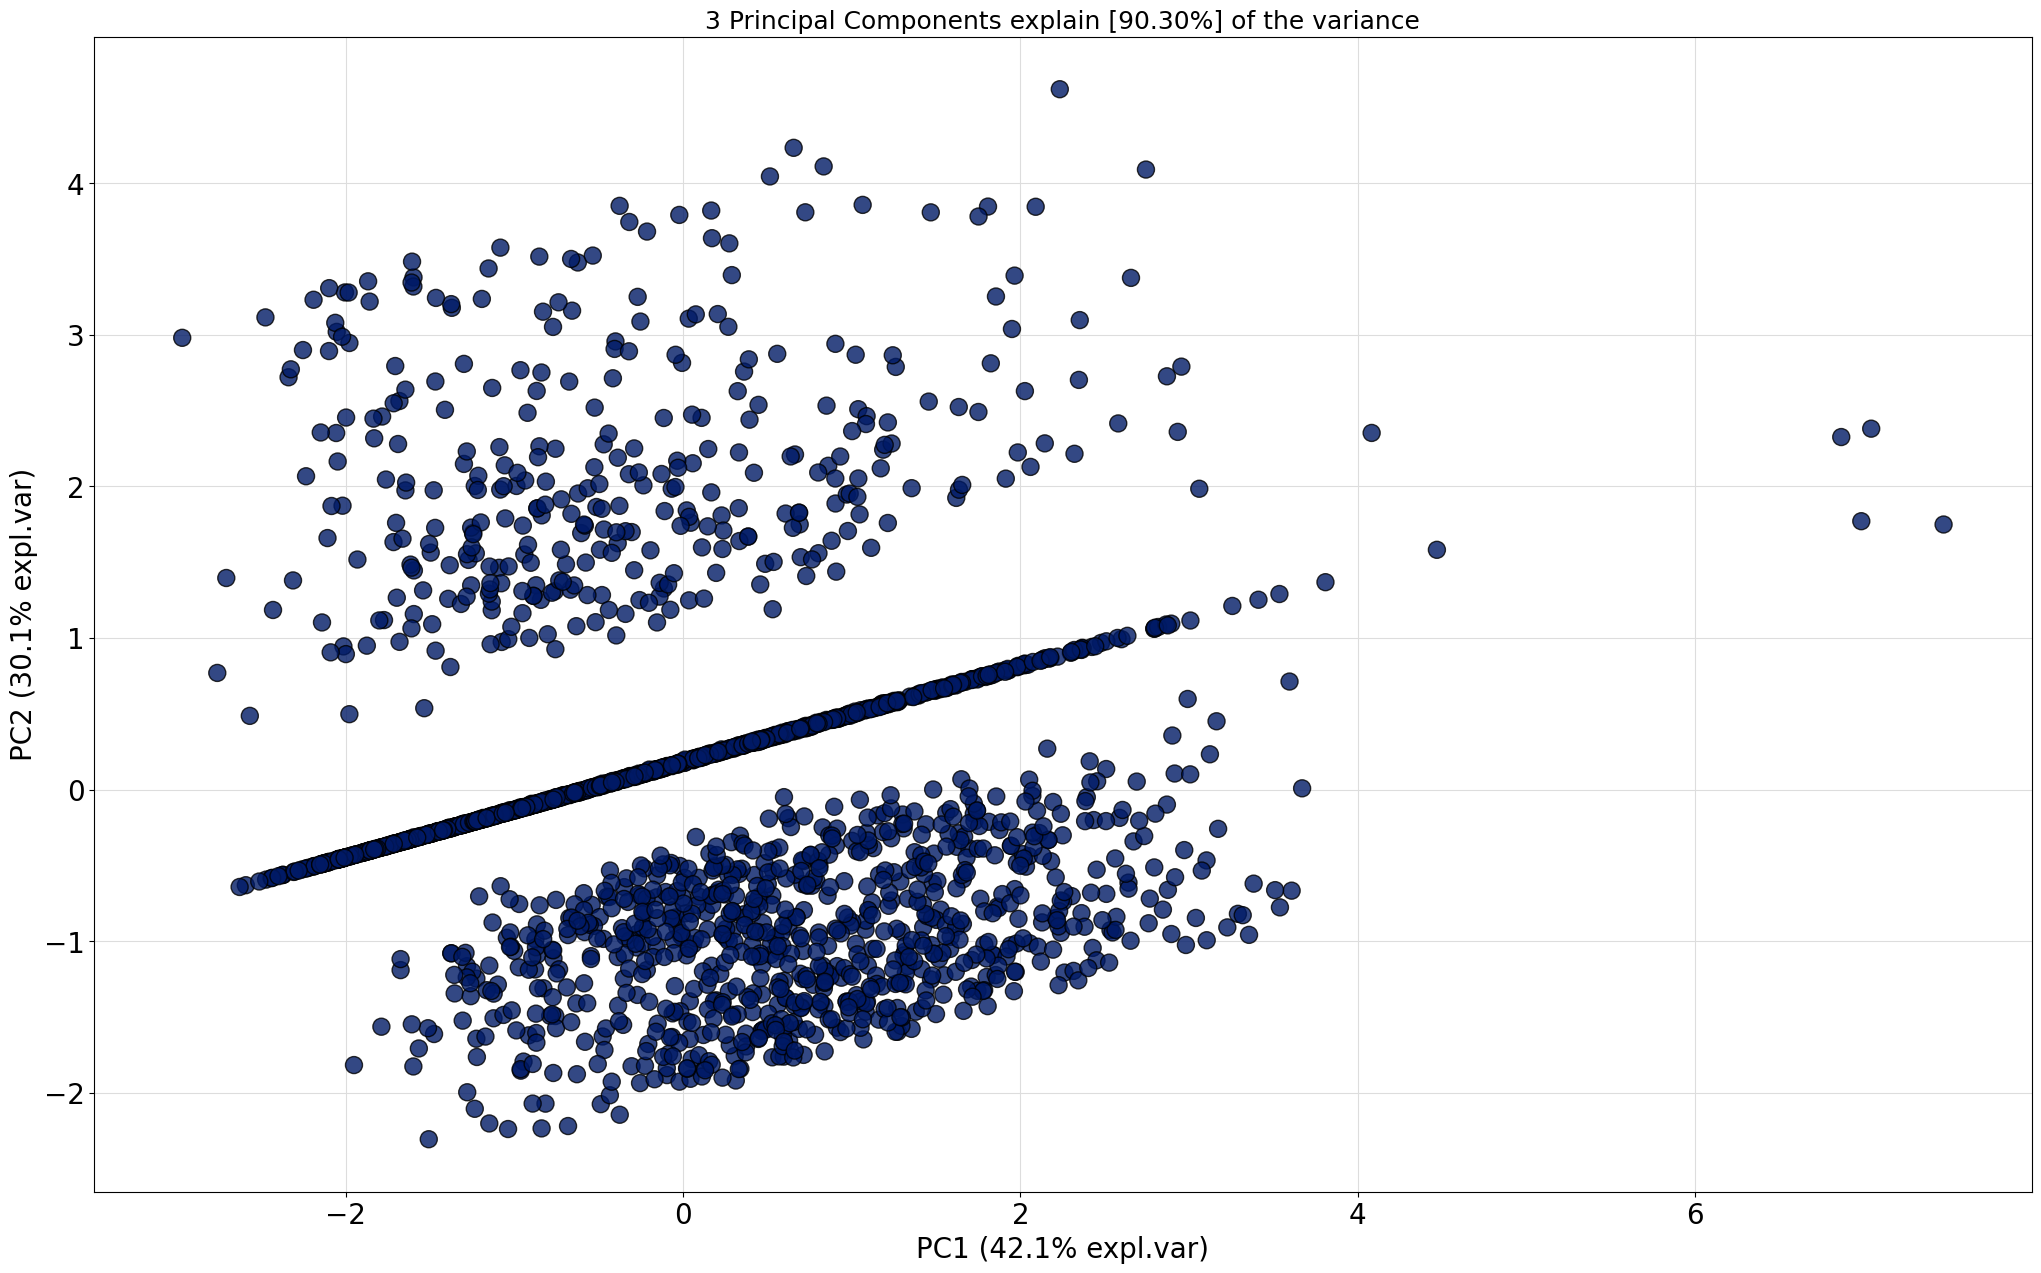

In [46]:
from pca import pca

# ... or explicitly specify the number of PCs
model3 = pca(n_components=3)

# Fit and transform
results = model3.fit_transform(X=scl3)

# Plot the explained variance
fig, ax = model3.plot()

# Scatter the first two PCs
fig, ax = model3.scatter()

In [408]:
# Scatter the first two PCs
#fig, ax = model3.scatter()
# for artist, group in model3.groupby('artist'):
#     ax.scatter(group['x'], group['y'], label=artist)

# ax.legend()
# plt.show()


[scatterd] >INFO> Create scatterplot


[pca] >Plot PC1 vs PC2 with loadings.
[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


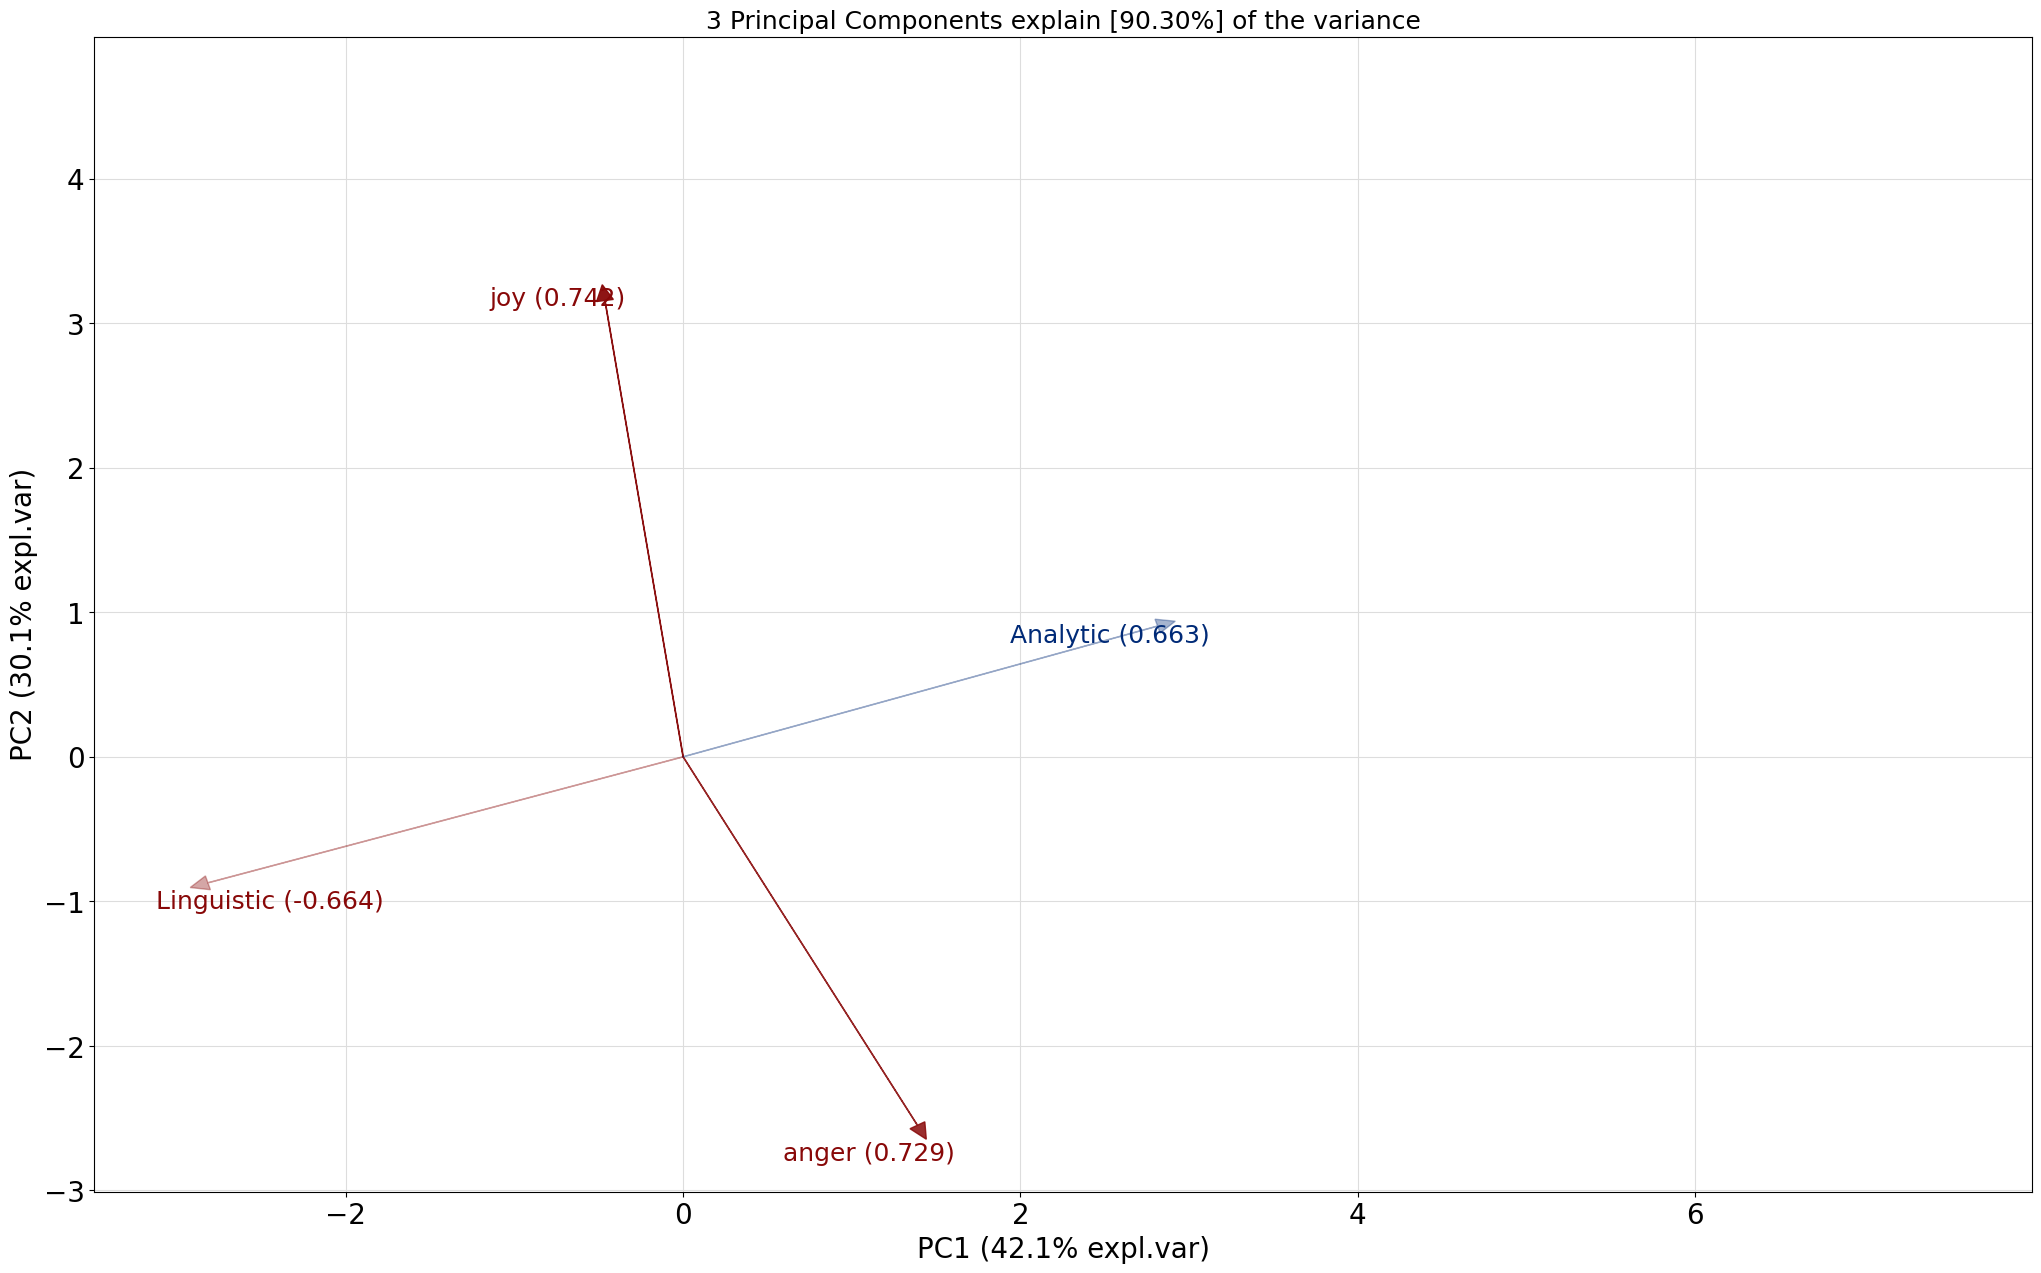

In [47]:
fig, ax = model3.biplot(n_feat=17, cmap=None)